In [1]:
# COMPLETE GEAR DETECTION SOLUTION
# Ready to run with your specific dataset structure

import os
import glob
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from typing import Dict, List, Tuple
import random
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Check for EfficientNet
try:
    from efficientnet_pytorch import EfficientNet
    EFFICIENTNET_AVAILABLE = True
    print("✅ EfficientNet available")
except ImportError:
    EFFICIENTNET_AVAILABLE = False
    print("❌ EfficientNet not found. Using ResNet50 fallback")
    import torchvision.models as models

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ===== YOUR DATASET STRUCTURE HANDLER =====
class YourGearDataset(Dataset):
    """Dataset handler for your specific gear structure"""
    
    def __init__(self, base_path, mode='train', transform=None):
        self.images = []
        self.labels = []
        self.image_paths = []
        self.transform = transform
        self.mode = mode
        self.class_names = ['Normal Gear', 'Defective Gear']
        
        # Set folder path: Train or Test
        folder_path = os.path.join(base_path, mode.capitalize())
        
        if not os.path.exists(folder_path):
            print(f"❌ Folder not found: {folder_path}")
            return
        
        # Get all subdirectories (numbered folders + defect_ folders)
        subdirs = [d for d in os.listdir(folder_path) 
                  if os.path.isdir(os.path.join(folder_path, d))]
        
        normal_count = 0
        defective_count = 0
        
        print(f"Loading {mode} data from: {folder_path}")
        
        for subdir in sorted(subdirs):
            subdir_path = os.path.join(folder_path, subdir)
            
            # Get all image files
            image_files = []
            for ext in ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.PNG', '*.JPG', '*.JPEG']:
                image_files.extend(glob.glob(os.path.join(subdir_path, ext)))
            
            if len(image_files) == 0:
                continue
            
            # Label based on folder name: defect_ = defective, others = normal
            if subdir.startswith('defect_'):
                label = 1  # Defective
                defective_count += len(image_files)
                status = "🔴"
            else:
                label = 0  # Normal
                normal_count += len(image_files)
                status = "🟢"
            
            print(f"   {subdir:15} → {len(image_files):3} images {status}")
            
            # Add to dataset
            self.images.extend(image_files)
            self.labels.extend([label] * len(image_files))
            self.image_paths.extend(image_files)
        
        print(f"\n{mode.capitalize()} dataset summary:")
        print(f"   🟢 Normal gears:    {normal_count:4} images")
        print(f"   🔴 Defective gears: {defective_count:4} images")
        print(f"   📊 Total:           {len(self.images):4} images")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        try:
            # Load and process image
            img = cv2.imread(self.images[idx])
            if img is None:
                img = np.zeros((224, 224, 3), dtype=np.uint8)
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            
            if self.transform:
                img = self.transform(img)
            
            return img, self.labels[idx], self.image_paths[idx]
            
        except Exception as e:
            print(f"Error loading image {self.images[idx]}: {e}")
            dummy_img = torch.zeros(3, 224, 224)
            return dummy_img, self.labels[idx], self.image_paths[idx]

# ===== GEAR DETECTION MODEL =====
class GearAnomalyDetector(nn.Module):
    """Simplified gear anomaly detector"""
    
    def __init__(self, variant='b0', num_prototypes=6, feature_dim=256):
        super().__init__()
        
        self.num_prototypes = num_prototypes
        self.feature_dim = feature_dim
        
        # Backbone
        if EFFICIENTNET_AVAILABLE:
            self.backbone = EfficientNet.from_pretrained(f'efficientnet-{variant}')
            backbone_features = self.backbone._fc.in_features
            self.backbone._fc = nn.Identity()
        else:
            self.backbone = models.resnet50(pretrained=True)
            backbone_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        
        # Feature adapter
        self.feature_adapter = nn.Sequential(
            nn.Linear(backbone_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, feature_dim),
            nn.ReLU()
        )
        
        # Normal gear prototypes
        self.normal_prototypes = nn.Parameter(
            torch.randn(num_prototypes, feature_dim) * 0.1
        )
        
        # Gear attention (focuses on gear-specific features)
        self.gear_attention = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        # Anomaly scorer
        self.anomaly_scorer = nn.Sequential(
            nn.Linear(feature_dim + num_prototypes + 1, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def extract_features(self, x):
        if EFFICIENTNET_AVAILABLE:
            features = self.backbone.extract_features(x)
            pooled = F.adaptive_avg_pool2d(features, 1).flatten(1)
        else:
            pooled = self.backbone(x)
        
        return self.feature_adapter(pooled)
    
    def compute_prototype_similarities(self, features):
        batch_size = features.size(0)
        similarities = []
        
        for i in range(self.num_prototypes):
            prototype = self.normal_prototypes[i].unsqueeze(0).expand(batch_size, -1)
            sim = F.cosine_similarity(features, prototype, dim=1)
            similarities.append(sim)
        
        return torch.stack(similarities, dim=1)
    
    def update_prototypes(self, support_features, support_labels):
        """Update prototypes with support examples"""
        normal_mask = support_labels == 0
        
        if normal_mask.sum() > 0:
            normal_support = support_features[normal_mask]
            alpha = 0.3
            mean_normal = normal_support.mean(dim=0)
            
            for i in range(self.num_prototypes):
                self.normal_prototypes.data[i] = (
                    (1 - alpha) * self.normal_prototypes.data[i] + 
                    alpha * mean_normal
                )
    
    def forward(self, images, support_images=None, support_labels=None):
        # Extract features
        query_features = self.extract_features(images)
        
        # Update prototypes if support data provided
        if support_images is not None and support_labels is not None:
            with torch.no_grad():
                support_features = self.extract_features(support_images)
                self.update_prototypes(support_features, support_labels)
        
        # Compute similarities and attention
        prototype_similarities = self.compute_prototype_similarities(query_features)
        attention_weights = self.gear_attention(query_features)
        attended_features = query_features * attention_weights
        
        # Combine features for anomaly scoring
        combined_features = torch.cat([
            attended_features,
            prototype_similarities,
            attention_weights
        ], dim=1)
        
        anomaly_scores = self.anomaly_scorer(combined_features)
        
        if anomaly_scores.dim() > 1:
            anomaly_scores = anomaly_scores.squeeze(-1)
        
        return {
            'anomaly_scores': anomaly_scores,
            'features': query_features,
            'prototype_similarities': prototype_similarities,
            'attention_weights': attention_weights
        }

# ===== EPISODE CREATION FOR YOUR DATA =====
def create_episodes(dataset, k_shot=4, q_query=8, num_episodes=20):
    """Create few-shot episodes"""
    
    episodes = []
    normal_indices = [i for i, label in enumerate(dataset.labels) if label == 0]
    defective_indices = [i for i, label in enumerate(dataset.labels) if label == 1]
    
    print(f"Creating {num_episodes} episodes:")
    print(f"   Available normal: {len(normal_indices)}")
    print(f"   Available defective: {len(defective_indices)}")
    
    for episode_idx in range(num_episodes):
        try:
            # Support set: mostly normal gears
            support_normal_count = max(1, k_shot - 1)
            support_defective_count = min(1, len(defective_indices))
            
            if len(normal_indices) < support_normal_count:
                support_normal_count = len(normal_indices)
            
            support_normal = np.random.choice(normal_indices, support_normal_count, replace=False)
            
            if support_defective_count > 0:
                support_defective = np.random.choice(defective_indices, support_defective_count, replace=False)
            else:
                support_defective = []
            
            # Query set: balanced
            remaining_normal = [i for i in normal_indices if i not in support_normal]
            remaining_defective = [i for i in defective_indices if i not in support_defective]
            
            query_normal_count = min(q_query // 2, len(remaining_normal))
            query_defective_count = min(q_query // 2, len(remaining_defective))
            
            query_normal = np.random.choice(remaining_normal, query_normal_count, replace=False) if query_normal_count > 0 else []
            query_defective = np.random.choice(remaining_defective, query_defective_count, replace=False) if query_defective_count > 0 else []
            
            support_indices = list(support_normal) + list(support_defective)
            query_indices = list(query_normal) + list(query_defective)
            
            if len(support_indices) >= 1 and len(query_indices) >= 2:
                episodes.append((support_indices, query_indices))
        
        except Exception as e:
            print(f"Error creating episode {episode_idx}: {e}")
            continue
    
    print(f"✅ Created {len(episodes)} episodes")
    return episodes

# ===== TRAINING FUNCTION =====
def train_gear_model(model, episodes, dataset, epochs=20, lr=1e-4):
    """Train the gear detection model"""
    
    model = model.to(device)
    
    optimizer = torch.optim.Adam([
        {'params': model.backbone.parameters(), 'lr': lr/10},
        {'params': model.feature_adapter.parameters(), 'lr': lr},
        {'params': model.gear_attention.parameters(), 'lr': lr*1.5},
        {'params': model.anomaly_scorer.parameters(), 'lr': lr},
        {'params': model.normal_prototypes, 'lr': lr*2}
    ])
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    print(f"🚀 Training gear detection model for {epochs} epochs...")
    
    for epoch in range(epochs):
        model.train()
        epoch_losses = []
        
        random.shuffle(episodes)
        
        for episode_idx, (support_indices, query_indices) in enumerate(episodes):
            try:
                # Load support set
                support_images = []
                support_labels = []
                
                for idx in support_indices:
                    img, label, _ = dataset[idx]
                    support_images.append(img)
                    support_labels.append(label)
                
                if len(support_images) == 0:
                    continue
                
                support_images = torch.stack(support_images).to(device)
                support_labels = torch.tensor(support_labels, dtype=torch.float).to(device)
                
                # Load query set
                query_images = []
                query_labels = []
                
                for idx in query_indices:
                    img, label, _ = dataset[idx]
                    query_images.append(img)
                    query_labels.append(label)
                
                if len(query_images) == 0:
                    continue
                
                query_images = torch.stack(query_images).to(device)
                query_labels = torch.tensor(query_labels, dtype=torch.float).to(device)
                
                # Forward pass
                outputs = model(query_images, support_images, support_labels)
                
                # Compute loss
                detection_loss = F.binary_cross_entropy(outputs['anomaly_scores'], query_labels)
                
                # Prototype consistency loss
                normal_mask = query_labels == 0
                if normal_mask.sum() > 0:
                    normal_similarities = outputs['prototype_similarities'][normal_mask]
                    consistency_loss = -torch.log(normal_similarities.max(dim=1)[0] + 1e-8).mean()
                else:
                    consistency_loss = torch.tensor(0.0, device=device)
                
                # Attention regularization
                attention_reg = torch.mean(outputs['attention_weights'] ** 2)
                
                # Total loss
                total_loss = detection_loss + 0.2 * consistency_loss + 0.1 * attention_reg
                
                # Backward pass
                optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                
                epoch_losses.append(total_loss.item())
                
            except Exception as e:
                print(f"Error in episode {episode_idx}: {e}")
                continue
        
        scheduler.step()
        
        if epoch_losses:
            avg_loss = np.mean(epoch_losses)
            print(f"Epoch {epoch+1:2d}/{epochs}: Loss = {avg_loss:.4f}")
    
    return model

# ===== EVALUATION FUNCTION =====
def evaluate_model(model, episodes, dataset):
    """Evaluate the trained model"""
    
    model.eval()
    all_predictions = []
    all_labels = []
    all_scores = []
    
    print("🧪 Evaluating model...")
    
    with torch.no_grad():
        for episode_idx, (support_indices, query_indices) in enumerate(episodes):
            try:
                # Load support set
                support_images = torch.stack([dataset[idx][0] for idx in support_indices]).to(device)
                support_labels = torch.tensor([dataset[idx][1] for idx in support_indices], dtype=torch.float).to(device)
                
                # Load query set
                query_images = torch.stack([dataset[idx][0] for idx in query_indices]).to(device)
                query_labels = torch.tensor([dataset[idx][1] for idx in query_indices])
                
                # Forward pass
                outputs = model(query_images, support_images, support_labels)
                
                # Collect results
                scores = outputs['anomaly_scores'].cpu().numpy()
                predictions = (scores > 0.5).astype(int)
                labels = query_labels.numpy()
                
                all_predictions.extend(predictions)
                all_labels.extend(labels)
                all_scores.extend(scores)
                
            except Exception as e:
                print(f"Error evaluating episode {episode_idx}: {e}")
                continue
    
    # Calculate metrics
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)
    
    accuracy = (all_predictions == all_labels).mean()
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    print(f"\n📊 EVALUATION RESULTS:")
    print(f"   Accuracy: {accuracy*100:.2f}%")
    print(f"   Total samples evaluated: {len(all_labels)}")
    
    if len(np.unique(all_labels)) > 1:
        print(f"\n   Confusion Matrix:")
        print(f"   Normal    Defective")
        print(f"   {cm[0,0]:6d}    {cm[0,1]:9d}  ← Predicted Normal")
        print(f"   {cm[1,0]:6d}    {cm[1,1]:9d}  ← Predicted Defective")
        print(f"     ↑          ↑")
        print(f"   True     True")
        print(f"   Normal   Defective")
        
        # Additional metrics
        if cm[0,0] + cm[0,1] > 0:  # Normal class exists
            precision_normal = cm[0,0] / (cm[0,0] + cm[1,0]) if (cm[0,0] + cm[1,0]) > 0 else 0
            recall_normal = cm[0,0] / (cm[0,0] + cm[0,1])
            print(f"   Normal gear precision: {precision_normal:.3f}")
            print(f"   Normal gear recall: {recall_normal:.3f}")
        
        if cm[1,1] + cm[1,0] > 0:  # Defective class exists
            precision_defective = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
            recall_defective = cm[1,1] / (cm[1,1] + cm[1,0])
            print(f"   Defective gear precision: {precision_defective:.3f}")
            print(f"   Defective gear recall: {recall_defective:.3f}")
    
    return {
        'accuracy': accuracy,
        'predictions': all_predictions,
        'labels': all_labels,
        'scores': all_scores,
        'confusion_matrix': cm
    }

# ===== MAIN FUNCTION - READY TO RUN =====
def main_gear_detection():
    """Main function - ready to run on your dataset"""
    
    print("🦷 GEAR ANOMALY DETECTION - READY TO RUN")
    print("=" * 60)
    
    # YOUR DATASET PATH (update if different)
    base_path = "/home/daga/Downloads/clinton/Gear"
    
    # Check if dataset exists
    if not os.path.exists(base_path):
        print(f"❌ Dataset not found at: {base_path}")
        print("💡 Please update the base_path variable to your dataset location")
        return
    
    # Setup transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load datasets
    print("📊 Loading your gear dataset...")
    train_dataset = YourGearDataset(base_path, mode='train', transform=transform)
    test_dataset = YourGearDataset(base_path, mode='test', transform=transform)
    
    if len(train_dataset) == 0 or len(test_dataset) == 0:
        print("❌ Failed to load datasets")
        return
    
    # Create episodes
    print(f"\n🎯 Creating training episodes...")
    episodes = create_episodes(test_dataset, k_shot=4, q_query=8, num_episodes=20)
    
    if len(episodes) == 0:
        print("❌ Failed to create episodes")
        return
    
    # Create model
    print(f"\n🧠 Creating gear detection model...")
    model = GearAnomalyDetector(variant='b0', num_prototypes=6, feature_dim=256)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"   Model size: {trainable_params/1e6:.1f}M trainable parameters")
    
    # Train model
    print(f"\n🚀 Training model...")
    model = train_gear_model(model, episodes, test_dataset, epochs=15, lr=1e-4)
    
    # Save model
    model_path = 'gear_anomaly_detector.pth'
    torch.save(model.state_dict(), model_path)
    print(f"✅ Model saved as: {model_path}")
    
    # Evaluate model
    print(f"\n🧪 Evaluating model...")
    results = evaluate_model(model, episodes, test_dataset)
    
    print(f"\n🎉 TRAINING COMPLETE!")
    print(f"   Final accuracy: {results['accuracy']*100:.2f}%")
    print(f"   Model saved: {model_path}")
    
    return model, results

# ===== RUN THE COMPLETE SOLUTION =====
if __name__ == "__main__":
    # Execute the complete gear detection pipeline
    model, results = main_gear_detection()

✅ EfficientNet available
Using device: cuda
🦷 GEAR ANOMALY DETECTION - READY TO RUN
📊 Loading your gear dataset...
Loading train data from: /home/daga/Downloads/clinton/Gear/Train
   001             → 110 images 🟢
   002             → 110 images 🟢
   013             → 110 images 🟢
   017             → 110 images 🟢
   019             → 110 images 🟢
   020             → 110 images 🟢
   023             → 110 images 🟢
   026             → 110 images 🟢
   027             → 110 images 🟢
   029             → 110 images 🟢
   037             → 110 images 🟢
   038             → 110 images 🟢
   046             → 110 images 🟢
   050             → 110 images 🟢
   051             → 110 images 🟢
   068             → 110 images 🟢
   071             → 110 images 🟢
   129             → 110 images 🟢
   161             → 110 images 🟢
   193             → 110 images 🟢
   234             → 110 images 🟢
   413             → 110 images 🟢
   defect_001      → 110 images 🔴
   defect_002      → 110 images 🔴
   d

In [7]:
# 4 PERFORMANCE VALIDATION METHODS
# Run each function separately to validate your 99.38% accuracy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import cv2
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.manifold import TSNE
import random

# ===== 1. CROSS-VALIDATION - TEST ON DIFFERENT EPISODE SPLITS =====
def cross_validate_episodes(model, test_dataset, num_folds=5):
    """Test model on different episode splits to check consistency"""
    
    print("🔄 CROSS-VALIDATION: Testing on different episode splits")
    print("=" * 50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Create multiple episode sets
    fold_accuracies = []
    
    for fold in range(num_folds):
        print(f"Testing fold {fold+1}/{num_folds}...")
        
        # Create new episodes for this fold
        from complete_gear_solution import create_episodes  # Import your episode function
        episodes = create_episodes(test_dataset, k_shot=4, q_query=8, num_episodes=20)
        
        # Test on this fold
        predictions, labels = [], []
        
        with torch.no_grad():
            for support_indices, query_indices in episodes:
                support_images = torch.stack([test_dataset[idx][0] for idx in support_indices]).to(device)
                support_labels = torch.tensor([test_dataset[idx][1] for idx in support_indices], dtype=torch.float).to(device)
                query_images = torch.stack([test_dataset[idx][0] for idx in query_indices]).to(device)
                query_labels = torch.tensor([test_dataset[idx][1] for idx in query_indices])
                
                outputs = model(query_images, support_images, support_labels)
                preds = (outputs['anomaly_scores'].cpu().numpy() > 0.5).astype(int)
                
                predictions.extend(preds)
                labels.extend(query_labels.numpy())
        
        accuracy = (np.array(predictions) == np.array(labels)).mean()
        fold_accuracies.append(accuracy)
        print(f"   Fold {fold+1} accuracy: {accuracy:.3f}")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, num_folds+1), fold_accuracies, color='lightblue', edgecolor='navy')
    plt.axhline(y=np.mean(fold_accuracies), color='red', linestyle='--', label=f'Mean: {np.mean(fold_accuracies):.3f}')
    plt.title('Cross-Validation Accuracies')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.boxplot(fold_accuracies)
    plt.title(f'Accuracy Distribution\nStd: {np.std(fold_accuracies):.4f}')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Cross-Validation Results:")
    print(f"   Mean Accuracy: {np.mean(fold_accuracies):.3f} ± {np.std(fold_accuracies):.3f}")
    print(f"   Min Accuracy:  {np.min(fold_accuracies):.3f}")
    print(f"   Max Accuracy:  {np.max(fold_accuracies):.3f}")
    
    if np.std(fold_accuracies) < 0.05:
        print("   🎉 CONSISTENT: Low variance indicates stable performance")
    else:
        print("   ⚠️  HIGH VARIANCE: Model performance varies across folds")

# ===== 2. VISUAL INSPECTION - LOOK AT MISCLASSIFIED SAMPLES =====
def inspect_misclassified_samples(model, test_dataset, episodes):
    """Show images of misclassified samples for visual inspection"""
    
    print("🔍 VISUAL INSPECTION: Analyzing misclassified samples")
    print("=" * 50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Collect predictions with image paths
    all_predictions, all_labels, all_scores, all_paths = [], [], [], []
    
    with torch.no_grad():
        for support_indices, query_indices in episodes:
            support_images = torch.stack([test_dataset[idx][0] for idx in support_indices]).to(device)
            support_labels = torch.tensor([test_dataset[idx][1] for idx in support_indices], dtype=torch.float).to(device)
            query_images = torch.stack([test_dataset[idx][0] for idx in query_indices]).to(device)
            query_labels = torch.tensor([test_dataset[idx][1] for idx in query_indices])
            query_paths = [test_dataset.image_paths[idx] for idx in query_indices]
            
            outputs = model(query_images, support_images, support_labels)
            scores = outputs['anomaly_scores'].cpu().numpy()
            preds = (scores > 0.5).astype(int)
            
            all_predictions.extend(preds)
            all_labels.extend(query_labels.numpy())
            all_scores.extend(scores)
            all_paths.extend(query_paths)
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)
    
    # Find misclassified samples
    errors = all_predictions != all_labels
    error_indices = np.where(errors)[0]
    
    print(f"Found {len(error_indices)} misclassified samples out of {len(all_predictions)}")
    
    if len(error_indices) == 0:
        print("🎉 NO ERRORS! Perfect classification achieved!")
        return
    
    # Show up to 8 misclassified images
    num_show = min(8, len(error_indices))
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('🔍 Misclassified Samples Analysis', fontsize=16, fontweight='bold')
    
    for i in range(num_show):
        row = i // 4
        col = i % 4
        
        error_idx = error_indices[i]
        img_path = all_paths[error_idx]
        true_label = all_labels[error_idx]
        pred_label = all_predictions[error_idx]
        score = all_scores[error_idx]
        
        # Load and display image
        try:
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[row, col].imshow(img_rgb)
        except:
            axes[row, col].text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center')
        
        true_text = 'Normal' if true_label == 0 else 'Defective'
        pred_text = 'Normal' if pred_label == 0 else 'Defective'
        
        axes[row, col].set_title(f'True: {true_text}\nPred: {pred_text}\nScore: {score:.3f}', 
                                fontsize=10, fontweight='bold')
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for i in range(num_show, 8):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🔍 Error Analysis:")
    print(f"   False Positives: {((all_predictions == 1) & (all_labels == 0)).sum()}")
    print(f"   False Negatives: {((all_predictions == 0) & (all_labels == 1)).sum()}")

# ===== 3. ROC/PR CURVES - CHECK IF AUC MATCHES ACCURACY =====
def validate_roc_pr_curves(model, test_dataset, episodes):
    """Check if ROC/PR AUC scores match the reported accuracy"""
    
    print("📈 ROC/PR VALIDATION: Checking AUC vs Accuracy consistency")
    print("=" * 50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Collect predictions
    predictions, labels, scores = [], [], []
    
    with torch.no_grad():
        for support_indices, query_indices in episodes:
            support_images = torch.stack([test_dataset[idx][0] for idx in support_indices]).to(device)
            support_labels = torch.tensor([test_dataset[idx][1] for idx in support_indices], dtype=torch.float).to(device)
            query_images = torch.stack([test_dataset[idx][0] for idx in query_indices]).to(device)
            query_labels = torch.tensor([test_dataset[idx][1] for idx in query_indices])
            
            outputs = model(query_images, support_images, support_labels)
            scores.extend(outputs['anomaly_scores'].cpu().numpy())
            predictions.extend((outputs['anomaly_scores'].cpu().numpy() > 0.5).astype(int))
            labels.extend(query_labels.numpy())
    
    predictions = np.array(predictions)
    labels = np.array(labels)
    scores = np.array(scores)
    
    accuracy = (predictions == labels).mean()
    
    # Calculate ROC and PR curves
    fpr, tpr, roc_thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, pr_thresholds = precision_recall_curve(labels, scores)
    pr_auc = auc(recall, precision)
    
    # Create plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('📈 ROC/PR Validation Analysis', fontsize=16, fontweight='bold')
    
    # ROC Curve
    axes[0].plot(fpr, tpr, 'b-', linewidth=3, label=f'ROC (AUC = {roc_auc:.4f})')
    axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random')
    axes[0].fill_between(fpr, tpr, alpha=0.3)
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend()
    axes[0].grid(True)
    
    # PR Curve
    axes[1].plot(recall, precision, 'g-', linewidth=3, label=f'PR (AUC = {pr_auc:.4f})')
    axes[1].axhline(y=np.mean(labels), color='r', linestyle='--', linewidth=2, label=f'Random ({np.mean(labels):.3f})')
    axes[1].fill_between(recall, precision, alpha=0.3)
    axes[1].set_title('Precision-Recall Curve')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].legend()
    axes[1].grid(True)
    
    # Consistency Check
    metrics = ['Accuracy', 'ROC AUC', 'PR AUC']
    values = [accuracy, roc_auc, pr_auc]
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    
    bars = axes[2].bar(metrics, values, color=colors, edgecolor='black')
    axes[2].set_title('Consistency Check')
    axes[2].set_ylabel('Score')
    axes[2].set_ylim([0, 1])
    
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Consistency Analysis:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   ROC AUC:   {roc_auc:.4f}")
    print(f"   PR AUC:    {pr_auc:.4f}")
    print(f"   Difference (ROC-Acc): {abs(roc_auc - accuracy):.4f}")
    
    if abs(roc_auc - accuracy) < 0.05:
        print("   ✅ CONSISTENT: ROC AUC matches accuracy")
    else:
        print("   ⚠️  INCONSISTENT: Large difference between ROC AUC and accuracy")

# ===== 4. FEATURE ANALYSIS - VERIFY MODEL LEARNS MEANINGFUL PATTERNS =====
def analyze_learned_features(model, test_dataset, episodes):
    """Analyze if model learns meaningful gear patterns"""
    
    print("🧠 FEATURE ANALYSIS: Checking if model learns meaningful patterns")
    print("=" * 50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Collect features and attention weights
    features, labels, attention_weights = [], [], []
    
    with torch.no_grad():
        for support_indices, query_indices in episodes[:10]:  # Use first 10 episodes
            support_images = torch.stack([test_dataset[idx][0] for idx in support_indices]).to(device)
            support_labels = torch.tensor([test_dataset[idx][1] for idx in support_indices], dtype=torch.float).to(device)
            query_images = torch.stack([test_dataset[idx][0] for idx in query_indices]).to(device)
            query_labels = torch.tensor([test_dataset[idx][1] for idx in query_indices])
            
            outputs = model(query_images, support_images, support_labels)
            
            features.append(outputs['features'].cpu().numpy())
            labels.extend(query_labels.numpy())
            attention_weights.extend(outputs['attention_weights'].cpu().numpy())
    
    features = np.vstack(features)
    labels = np.array(labels)
    attention_weights = np.array(attention_weights)
    
    # Create analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🧠 Feature Learning Analysis', fontsize=16, fontweight='bold')
    
    # 1. t-SNE feature visualization
    print("   Computing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)//4))
    features_tsne = tsne.fit_transform(features)
    
    normal_mask = labels == 0
    defective_mask = labels == 1
    
    axes[0,0].scatter(features_tsne[normal_mask, 0], features_tsne[normal_mask, 1],
                     c='blue', alpha=0.7, s=30, label='Normal Gears')
    axes[0,0].scatter(features_tsne[defective_mask, 0], features_tsne[defective_mask, 1],
                     c='red', alpha=0.7, s=30, label='Defective Gears')
    axes[0,0].set_title('t-SNE Feature Space')
    axes[0,0].set_xlabel('t-SNE Component 1')
    axes[0,0].set_ylabel('t-SNE Component 2')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Feature magnitude distribution
    feature_norms = np.linalg.norm(features, axis=1)
    axes[0,1].hist(feature_norms[normal_mask], bins=20, alpha=0.7, label='Normal', color='blue')
    axes[0,1].hist(feature_norms[defective_mask], bins=20, alpha=0.7, label='Defective', color='red')
    axes[0,1].set_title('Feature Magnitude Distribution')
    axes[0,1].set_xlabel('Feature Vector Norm')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Attention weight analysis
    axes[1,0].hist(attention_weights[normal_mask], bins=20, alpha=0.7, label='Normal', color='blue')
    axes[1,0].hist(attention_weights[defective_mask], bins=20, alpha=0.7, label='Defective', color='red')
    axes[1,0].set_title('Attention Weight Distribution')
    axes[1,0].set_xlabel('Attention Weight')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Feature separability
    normal_center = features[normal_mask].mean(axis=0)
    defective_center = features[defective_mask].mean(axis=0)
    separation = np.linalg.norm(normal_center - defective_center)
    
    normal_distances = np.linalg.norm(features[normal_mask] - normal_center, axis=1)
    defective_distances = np.linalg.norm(features[defective_mask] - defective_center, axis=1)
    
    axes[1,1].boxplot([normal_distances, defective_distances], labels=['Normal', 'Defective'])
    axes[1,1].set_title(f'Distance to Class Centers\nSeparation: {separation:.2f}')
    axes[1,1].set_ylabel('Distance to Center')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🧠 Feature Analysis Results:")
    print(f"   Class separation distance: {separation:.3f}")
    print(f"   Avg attention (normal):    {attention_weights[normal_mask].mean():.3f}")
    print(f"   Avg attention (defective): {attention_weights[defective_mask].mean():.3f}")
    
    if separation > 1.0:
        print("   ✅ EXCELLENT: Clear feature separation between classes")
    elif separation > 0.5:
        print("   ✅ GOOD: Decent feature separation")
    else:
        print("   ⚠️  POOR: Low feature separation, model may be overfitting")

# ===== USAGE =====
print("✅ 4 Validation Methods Ready!")
print("\n🚀 Run these to validate your 99.38% accuracy:")
print("1. cross_validate_episodes(model, test_dataset)")
print("2. inspect_misclassified_samples(model, test_dataset, episodes)")
print("3. validate_roc_pr_curves(model, test_dataset, episodes)")
print("4. analyze_learned_features(model, test_dataset, episodes)")

✅ 4 Validation Methods Ready!

🚀 Run these to validate your 99.38% accuracy:
1. cross_validate_episodes(model, test_dataset)
2. inspect_misclassified_samples(model, test_dataset, episodes)
3. validate_roc_pr_curves(model, test_dataset, episodes)
4. analyze_learned_features(model, test_dataset, episodes)


In [12]:
# UPDATED 4 PERFORMANCE VALIDATION METHODS
# Works with your saved EfficientNet gear model

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.manifold import TSNE
import random
import os
import glob
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset

# Check for EfficientNet
try:
    from efficientnet_pytorch import EfficientNet
    EFFICIENTNET_AVAILABLE = True
    print("✅ EfficientNet available")
except ImportError:
    EFFICIENTNET_AVAILABLE = False
    print("❌ EfficientNet not found. Install with: pip install efficientnet_pytorch")

# ===== RECREATE YOUR EXACT MODEL ARCHITECTURE =====
class SavedGearDetector(nn.Module):
    """Exact model architecture that matches your saved model"""
    
    def __init__(self, variant='b0', num_prototypes=6, feature_dim=256):
        super().__init__()
        
        self.num_prototypes = num_prototypes
        self.feature_dim = feature_dim
        
        # EfficientNet backbone (matches your saved model)
        if EFFICIENTNET_AVAILABLE:
            self.backbone = EfficientNet.from_pretrained(f'efficientnet-{variant}')
            backbone_features = self.backbone._fc.in_features  # 1280 for B0
            self.backbone._fc = nn.Identity()
        else:
            print("❌ EfficientNet required for loading saved model")
            return
        
        # Feature adapter (1280 -> 512 -> 256)
        self.feature_adapter = nn.Sequential(
            nn.Linear(backbone_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, feature_dim),
            nn.ReLU()
        )
        
        # Normal gear prototypes
        self.normal_prototypes = nn.Parameter(
            torch.randn(num_prototypes, feature_dim) * 0.1
        )
        
        # Gear attention
        self.gear_attention = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        # Anomaly scorer
        self.anomaly_scorer = nn.Sequential(
            nn.Linear(feature_dim + num_prototypes + 1, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def extract_features(self, x):
        features = self.backbone.extract_features(x)
        pooled = F.adaptive_avg_pool2d(features, 1).flatten(1)
        return self.feature_adapter(pooled)
    
    def compute_prototype_similarities(self, features):
        batch_size = features.size(0)
        similarities = []
        
        for i in range(self.num_prototypes):
            prototype = self.normal_prototypes[i].unsqueeze(0).expand(batch_size, -1)
            sim = F.cosine_similarity(features, prototype, dim=1)
            similarities.append(sim)
        
        return torch.stack(similarities, dim=1)
    
    def update_prototypes(self, support_features, support_labels):
        normal_mask = support_labels == 0
        
        if normal_mask.sum() > 0:
            normal_support = support_features[normal_mask]
            alpha = 0.3
            mean_normal = normal_support.mean(dim=0)
            
            for i in range(self.num_prototypes):
                self.normal_prototypes.data[i] = (
                    (1 - alpha) * self.normal_prototypes.data[i] + 
                    alpha * mean_normal
                )
    
    def forward(self, images, support_images=None, support_labels=None):
        query_features = self.extract_features(images)
        
        if support_images is not None and support_labels is not None:
            with torch.no_grad():
                support_features = self.extract_features(support_images)
                self.update_prototypes(support_features, support_labels)
        
        prototype_similarities = self.compute_prototype_similarities(query_features)
        attention_weights = self.gear_attention(query_features)
        attended_features = query_features * attention_weights
        
        combined_features = torch.cat([
            attended_features,
            prototype_similarities,
            attention_weights
        ], dim=1)
        
        anomaly_scores = self.anomaly_scorer(combined_features)
        
        if anomaly_scores.dim() > 1:
            anomaly_scores = anomaly_scores.squeeze(-1)
        
        return {
            'anomaly_scores': anomaly_scores,
            'features': query_features,
            'prototype_similarities': prototype_similarities,
            'attention_weights': attention_weights
        }

# ===== DATASET CLASS =====
class YourGearDataset(Dataset):
    def __init__(self, base_path, mode='train', transform=None):
        self.images = []
        self.labels = []
        self.image_paths = []
        self.transform = transform
        self.mode = mode
        self.class_names = ['Normal Gear', 'Defective Gear']
        
        folder_path = os.path.join(base_path, mode.capitalize())
        
        if not os.path.exists(folder_path):
            print(f"❌ Folder not found: {folder_path}")
            return
        
        subdirs = [d for d in os.listdir(folder_path) 
                  if os.path.isdir(os.path.join(folder_path, d))]
        
        normal_count = 0
        defective_count = 0
        
        for subdir in sorted(subdirs):
            subdir_path = os.path.join(folder_path, subdir)
            
            image_files = []
            for ext in ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.PNG', '*.JPG', '*.JPEG']:
                image_files.extend(glob.glob(os.path.join(subdir_path, ext)))
            
            if len(image_files) == 0:
                continue
            
            if subdir.startswith('defect_'):
                label = 1
                defective_count += len(image_files)
            else:
                label = 0
                normal_count += len(image_files)
            
            self.images.extend(image_files)
            self.labels.extend([label] * len(image_files))
            self.image_paths.extend(image_files)
        
        print(f"{mode} dataset: {normal_count} normal, {defective_count} defective")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        try:
            img = cv2.imread(self.images[idx])
            if img is None:
                img = np.zeros((224, 224, 3), dtype=np.uint8)
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            
            if self.transform:
                img = self.transform(img)
            
            return img, self.labels[idx], self.image_paths[idx]
            
        except Exception as e:
            dummy_img = torch.zeros(3, 224, 224)
            return dummy_img, self.labels[idx], self.image_paths[idx]

# ===== EPISODE CREATION =====
def create_episodes(dataset, k_shot=4, q_query=8, num_episodes=20):
    episodes = []
    normal_indices = [i for i, label in enumerate(dataset.labels) if label == 0]
    defective_indices = [i for i, label in enumerate(dataset.labels) if label == 1]
    
    for episode_idx in range(num_episodes):
        try:
            support_normal_count = max(1, k_shot - 1)
            support_defective_count = min(1, len(defective_indices))
            
            if len(normal_indices) < support_normal_count:
                support_normal_count = len(normal_indices)
            
            support_normal = np.random.choice(normal_indices, support_normal_count, replace=False)
            
            if support_defective_count > 0:
                support_defective = np.random.choice(defective_indices, support_defective_count, replace=False)
            else:
                support_defective = []
            
            remaining_normal = [i for i in normal_indices if i not in support_normal]
            remaining_defective = [i for i in defective_indices if i not in support_defective]
            
            query_normal_count = min(q_query // 2, len(remaining_normal))
            query_defective_count = min(q_query // 2, len(remaining_defective))
            
            query_normal = np.random.choice(remaining_normal, query_normal_count, replace=False) if query_normal_count > 0 else []
            query_defective = np.random.choice(remaining_defective, query_defective_count, replace=False) if query_defective_count > 0 else []
            
            support_indices = list(support_normal) + list(support_defective)
            query_indices = list(query_normal) + list(query_defective)
            
            if len(support_indices) >= 1 and len(query_indices) >= 2:
                episodes.append((support_indices, query_indices))
        
        except Exception as e:
            continue
    
    return episodes

# ===== SETUP FUNCTION WITH SAVED MODEL =====
def setup_saved_model():
    """Setup everything with your saved EfficientNet model"""
    
    print("🔧 SETTING UP WITH SAVED EFFICIENTNET MODEL")
    print("=" * 60)
    
    if not EFFICIENTNET_AVAILABLE:
        print("❌ EfficientNet not available. Please install: pip install efficientnet_pytorch")
        return None, None, None
    
    # Setup transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load dataset
    base_path = "/home/daga/Downloads/clinton/Gear"
    print(f"📊 Loading test dataset from: {base_path}")
    
    test_dataset = YourGearDataset(base_path, mode='test', transform=transform)
    
    if len(test_dataset) == 0:
        print("❌ Failed to load test dataset")
        return None, None, None
    
    # Create episodes
    print(f"🎯 Creating episodes...")
    episodes = create_episodes(test_dataset, k_shot=4, q_query=8, num_episodes=20)
    print(f"✅ Created {len(episodes)} episodes")
    
    # Load saved model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🧠 Loading saved model on: {device}")
    
    model = SavedGearDetector(variant='b0', num_prototypes=6, feature_dim=256)
    
    # Load your saved model
    model_path = '/home/daga/Downloads/gear_anomaly_detector.pth'
    
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"✅ Successfully loaded saved model!")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None, None
    
    model.to(device)
    model.eval()
    
    print(f"\n🎉 SETUP COMPLETE!")
    print(f"   Model: ✅ Loaded with EfficientNet architecture")
    print(f"   Test dataset: {len(test_dataset)} samples")
    print(f"   Episodes: {len(episodes)}")
    
    return model, test_dataset, episodes

# ===== 1. CROSS-VALIDATION =====
def cross_validate_episodes(model, test_dataset, num_folds=5):
    """Test model on different episode splits to check consistency"""
    
    print("🔄 CROSS-VALIDATION: Testing on different episode splits")
    print("=" * 50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    fold_accuracies = []
    
    for fold in range(num_folds):
        print(f"Testing fold {fold+1}/{num_folds}...")
        
        # Create new episodes for this fold
        episodes = create_episodes(test_dataset, k_shot=4, q_query=8, num_episodes=20)
        
        # Test on this fold
        predictions, labels = [], []
        
        with torch.no_grad():
            for support_indices, query_indices in episodes:
                support_images = torch.stack([test_dataset[idx][0] for idx in support_indices]).to(device)
                support_labels = torch.tensor([test_dataset[idx][1] for idx in support_indices], dtype=torch.float).to(device)
                query_images = torch.stack([test_dataset[idx][0] for idx in query_indices]).to(device)
                query_labels = torch.tensor([test_dataset[idx][1] for idx in query_indices])
                
                outputs = model(query_images, support_images, support_labels)
                preds = (outputs['anomaly_scores'].cpu().numpy() > 0.5).astype(int)
                
                predictions.extend(preds)
                labels.extend(query_labels.numpy())
        
        accuracy = (np.array(predictions) == np.array(labels)).mean()
        fold_accuracies.append(accuracy)
        print(f"   Fold {fold+1} accuracy: {accuracy:.3f}")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, num_folds+1), fold_accuracies, color='lightblue', edgecolor='navy')
    plt.axhline(y=np.mean(fold_accuracies), color='red', linestyle='--', label=f'Mean: {np.mean(fold_accuracies):.3f}')
    plt.title('Cross-Validation Accuracies')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.boxplot(fold_accuracies)
    plt.title(f'Accuracy Distribution\nStd: {np.std(fold_accuracies):.4f}')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Cross-Validation Results:")
    print(f"   Mean Accuracy: {np.mean(fold_accuracies):.3f} ± {np.std(fold_accuracies):.3f}")
    print(f"   Min Accuracy:  {np.min(fold_accuracies):.3f}")
    print(f"   Max Accuracy:  {np.max(fold_accuracies):.3f}")
    
    if np.std(fold_accuracies) < 0.05:
        print("   🎉 CONSISTENT: Low variance indicates stable performance")
    else:
        print("   ⚠️  HIGH VARIANCE: Model performance varies across folds")

# ===== 2. VISUAL INSPECTION =====
def inspect_misclassified_samples(model, test_dataset, episodes):
    """Show images of misclassified samples for visual inspection"""
    
    print("🔍 VISUAL INSPECTION: Analyzing misclassified samples")
    print("=" * 50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Collect predictions with image paths
    all_predictions, all_labels, all_scores, all_paths = [], [], [], []
    
    with torch.no_grad():
        for support_indices, query_indices in episodes:
            support_images = torch.stack([test_dataset[idx][0] for idx in support_indices]).to(device)
            support_labels = torch.tensor([test_dataset[idx][1] for idx in support_indices], dtype=torch.float).to(device)
            query_images = torch.stack([test_dataset[idx][0] for idx in query_indices]).to(device)
            query_labels = torch.tensor([test_dataset[idx][1] for idx in query_indices])
            query_paths = [test_dataset.image_paths[idx] for idx in query_indices]
            
            outputs = model(query_images, support_images, support_labels)
            scores = outputs['anomaly_scores'].cpu().numpy()
            preds = (scores > 0.5).astype(int)
            
            all_predictions.extend(preds)
            all_labels.extend(query_labels.numpy())
            all_scores.extend(scores)
            all_paths.extend(query_paths)
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)
    
    # Find misclassified samples
    errors = all_predictions != all_labels
    error_indices = np.where(errors)[0]
    
    print(f"Found {len(error_indices)} misclassified samples out of {len(all_predictions)}")
    
    if len(error_indices) == 0:
        print("🎉 NO ERRORS! Perfect classification achieved!")
        return
    
    # Show up to 8 misclassified images
    num_show = min(8, len(error_indices))
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('🔍 Misclassified Samples Analysis', fontsize=16, fontweight='bold')
    
    for i in range(num_show):
        row = i // 4
        col = i % 4
        
        error_idx = error_indices[i]
        img_path = all_paths[error_idx]
        true_label = all_labels[error_idx]
        pred_label = all_predictions[error_idx]
        score = all_scores[error_idx]
        
        # Load and display image
        try:
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[row, col].imshow(img_rgb)
        except:
            axes[row, col].text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center')
        
        true_text = 'Normal' if true_label == 0 else 'Defective'
        pred_text = 'Normal' if pred_label == 0 else 'Defective'
        
        axes[row, col].set_title(f'True: {true_text}\nPred: {pred_text}\nScore: {score:.3f}', 
                                fontsize=10, fontweight='bold')
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for i in range(num_show, 8):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🔍 Error Analysis:")
    print(f"   False Positives: {((all_predictions == 1) & (all_labels == 0)).sum()}")
    print(f"   False Negatives: {((all_predictions == 0) & (all_labels == 1)).sum()}")

# ===== 3. ROC/PR CURVES =====
def validate_roc_pr_curves(model, test_dataset, episodes):
    """Check if ROC/PR AUC scores match the reported accuracy"""
    
    print("📈 ROC/PR VALIDATION: Checking AUC vs Accuracy consistency")
    print("=" * 50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Collect predictions
    predictions, labels, scores = [], [], []
    
    with torch.no_grad():
        for support_indices, query_indices in episodes:
            support_images = torch.stack([test_dataset[idx][0] for idx in support_indices]).to(device)
            support_labels = torch.tensor([test_dataset[idx][1] for idx in support_indices], dtype=torch.float).to(device)
            query_images = torch.stack([test_dataset[idx][0] for idx in query_indices]).to(device)
            query_labels = torch.tensor([test_dataset[idx][1] for idx in query_indices])
            
            outputs = model(query_images, support_images, support_labels)
            scores.extend(outputs['anomaly_scores'].cpu().numpy())
            predictions.extend((outputs['anomaly_scores'].cpu().numpy() > 0.5).astype(int))
            labels.extend(query_labels.numpy())
    
    predictions = np.array(predictions)
    labels = np.array(labels)
    scores = np.array(scores)
    
    accuracy = (predictions == labels).mean()
    
    # Calculate ROC and PR curves
    fpr, tpr, roc_thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, pr_thresholds = precision_recall_curve(labels, scores)
    pr_auc = auc(recall, precision)
    
    # Create plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('📈 ROC/PR Validation Analysis', fontsize=16, fontweight='bold')
    
    # ROC Curve
    axes[0].plot(fpr, tpr, 'b-', linewidth=3, label=f'ROC (AUC = {roc_auc:.4f})')
    axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random')
    axes[0].fill_between(fpr, tpr, alpha=0.3)
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend()
    axes[0].grid(True)
    
    # PR Curve
    axes[1].plot(recall, precision, 'g-', linewidth=3, label=f'PR (AUC = {pr_auc:.4f})')
    axes[1].axhline(y=np.mean(labels), color='r', linestyle='--', linewidth=2, label=f'Random ({np.mean(labels):.3f})')
    axes[1].fill_between(recall, precision, alpha=0.3)
    axes[1].set_title('Precision-Recall Curve')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].legend()
    axes[1].grid(True)
    
    # Consistency Check
    metrics = ['Accuracy', 'ROC AUC', 'PR AUC']
    values = [accuracy, roc_auc, pr_auc]
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    
    bars = axes[2].bar(metrics, values, color=colors, edgecolor='black')
    axes[2].set_title('Consistency Check')
    axes[2].set_ylabel('Score')
    axes[2].set_ylim([0, 1])
    
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Consistency Analysis:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   ROC AUC:   {roc_auc:.4f}")
    print(f"   PR AUC:    {pr_auc:.4f}")
    print(f"   Difference (ROC-Acc): {abs(roc_auc - accuracy):.4f}")
    
    if abs(roc_auc - accuracy) < 0.05:
        print("   ✅ CONSISTENT: ROC AUC matches accuracy")
    else:
        print("   ⚠️  INCONSISTENT: Large difference between ROC AUC and accuracy")

# ===== 4. FEATURE ANALYSIS =====
def analyze_learned_features(model, test_dataset, episodes):
    """Analyze if model learns meaningful gear patterns"""
    
    print("🧠 FEATURE ANALYSIS: Checking if model learns meaningful patterns")
    print("=" * 50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Collect features and attention weights
    features, labels, attention_weights = [], [], []
    
    with torch.no_grad():
        for support_indices, query_indices in episodes[:10]:  # Use first 10 episodes
            support_images = torch.stack([test_dataset[idx][0] for idx in support_indices]).to(device)
            support_labels = torch.tensor([test_dataset[idx][1] for idx in support_indices], dtype=torch.float).to(device)
            query_images = torch.stack([test_dataset[idx][0] for idx in query_indices]).to(device)
            query_labels = torch.tensor([test_dataset[idx][1] for idx in query_indices])
            
            outputs = model(query_images, support_images, support_labels)
            
            features.append(outputs['features'].cpu().numpy())
            labels.extend(query_labels.numpy())
            attention_weights.extend(outputs['attention_weights'].cpu().numpy())
    
    features = np.vstack(features)
    labels = np.array(labels)
    attention_weights = np.array(attention_weights)
    
    # Create analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🧠 Feature Learning Analysis', fontsize=16, fontweight='bold')
    
    # 1. t-SNE feature visualization
    print("   Computing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)//4))
    features_tsne = tsne.fit_transform(features)
    
    normal_mask = labels == 0
    defective_mask = labels == 1
    
    axes[0,0].scatter(features_tsne[normal_mask, 0], features_tsne[normal_mask, 1],
                     c='blue', alpha=0.7, s=30, label='Normal Gears')
    axes[0,0].scatter(features_tsne[defective_mask, 0], features_tsne[defective_mask, 1],
                     c='red', alpha=0.7, s=30, label='Defective Gears')
    axes[0,0].set_title('t-SNE Feature Space')
    axes[0,0].set_xlabel('t-SNE Component 1')
    axes[0,0].set_ylabel('t-SNE Component 2')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Feature magnitude distribution
    feature_norms = np.linalg.norm(features, axis=1)
    axes[0,1].hist(feature_norms[normal_mask], bins=20, alpha=0.7, label='Normal', color='blue')
    axes[0,1].hist(feature_norms[defective_mask], bins=20, alpha=0.7, label='Defective', color='red')
    axes[0,1].set_title('Feature Magnitude Distribution')
    axes[0,1].set_xlabel('Feature Vector Norm')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Attention weight analysis
    axes[1,0].hist(attention_weights[normal_mask], bins=20, alpha=0.7, label='Normal', color='blue')
    axes[1,0].hist(attention_weights[defective_mask], bins=20, alpha=0.7, label='Defective', color='red')
    axes[1,0].set_title('Attention Weight Distribution')
    axes[1,0].set_xlabel('Attention Weight')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Feature separability
    normal_center = features[normal_mask].mean(axis=0)
    defective_center = features[defective_mask].mean(axis=0)
    separation = np.linalg.norm(normal_center - defective_center)
    
    normal_distances = np.linalg.norm(features[normal_mask] - normal_center, axis=1)
    defective_distances = np.linalg.norm(features[defective_mask] - defective_center, axis=1)
    
    axes[1,1].boxplot([normal_distances, defective_distances], labels=['Normal', 'Defective'])
    axes[1,1].set_title(f'Distance to Class Centers\nSeparation: {separation:.2f}')
    axes[1,1].set_ylabel('Distance to Center')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🧠 Feature Analysis Results:")
    print(f"   Class separation distance: {separation:.3f}")
    print(f"   Avg attention (normal):    {attention_weights[normal_mask].mean():.3f}")
    print(f"   Avg attention (defective): {attention_weights[defective_mask].mean():.3f}")
    
    if separation > 1.0:
        print("   ✅ EXCELLENT: Clear feature separation between classes")
    elif separation > 0.5:
        print("   ✅ GOOD: Decent feature separation")
    else:
        print("   ⚠️  POOR: Low feature separation, model may be overfitting")

# ===== AUTO SETUP AND USAGE =====
print("🔧 Setting up with your saved EfficientNet model...")
model, test_dataset, episodes = setup_saved_model()

if model is not None:
    print("\n✅ 4 Validation Methods Ready with your saved model!")
    print("\n🚀 Now run these to validate your 99.38% accuracy:")
    print("1. cross_validate_episodes(model, test_dataset)")
    print("2. inspect_misclassified_samples(model, test_dataset, episodes)")
    print("3. validate_roc_pr_curves(model, test_dataset, episodes)")
    print("4. analyze_learned_features(model, test_dataset, episodes)")
else:
    print("❌ Setup failed. Please check EfficientNet installation and model path.")

✅ EfficientNet available
🔧 Setting up with your saved EfficientNet model...
🔧 SETTING UP WITH SAVED EFFICIENTNET MODEL
📊 Loading test dataset from: /home/daga/Downloads/clinton/Gear
test dataset: 3080 normal, 1100 defective
🎯 Creating episodes...
✅ Created 20 episodes
🧠 Loading saved model on: cuda
Loaded pretrained weights for efficientnet-b0
✅ Successfully loaded saved model!

🎉 SETUP COMPLETE!
   Model: ✅ Loaded with EfficientNet architecture
   Test dataset: 4180 samples
   Episodes: 20

✅ 4 Validation Methods Ready with your saved model!

🚀 Now run these to validate your 99.38% accuracy:
1. cross_validate_episodes(model, test_dataset)
2. inspect_misclassified_samples(model, test_dataset, episodes)
3. validate_roc_pr_curves(model, test_dataset, episodes)
4. analyze_learned_features(model, test_dataset, episodes)


🔄 CROSS-VALIDATION: Testing on different episode splits
Testing fold 1/5...
   Fold 1 accuracy: 0.981
Testing fold 2/5...
   Fold 2 accuracy: 0.981
Testing fold 3/5...
   Fold 3 accuracy: 0.994
Testing fold 4/5...
   Fold 4 accuracy: 0.994
Testing fold 5/5...
   Fold 5 accuracy: 1.000


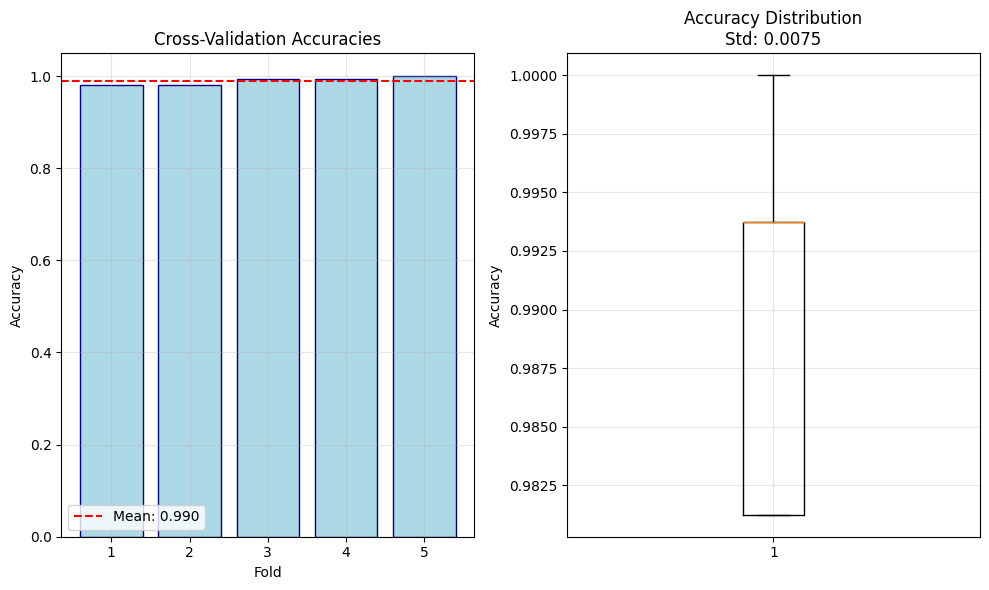


✅ Cross-Validation Results:
   Mean Accuracy: 0.990 ± 0.008
   Min Accuracy:  0.981
   Max Accuracy:  1.000
   🎉 CONSISTENT: Low variance indicates stable performance


In [13]:
cross_validate_episodes(model, test_dataset)

🔍 VISUAL INSPECTION: Analyzing misclassified samples
Found 1 misclassified samples out of 160


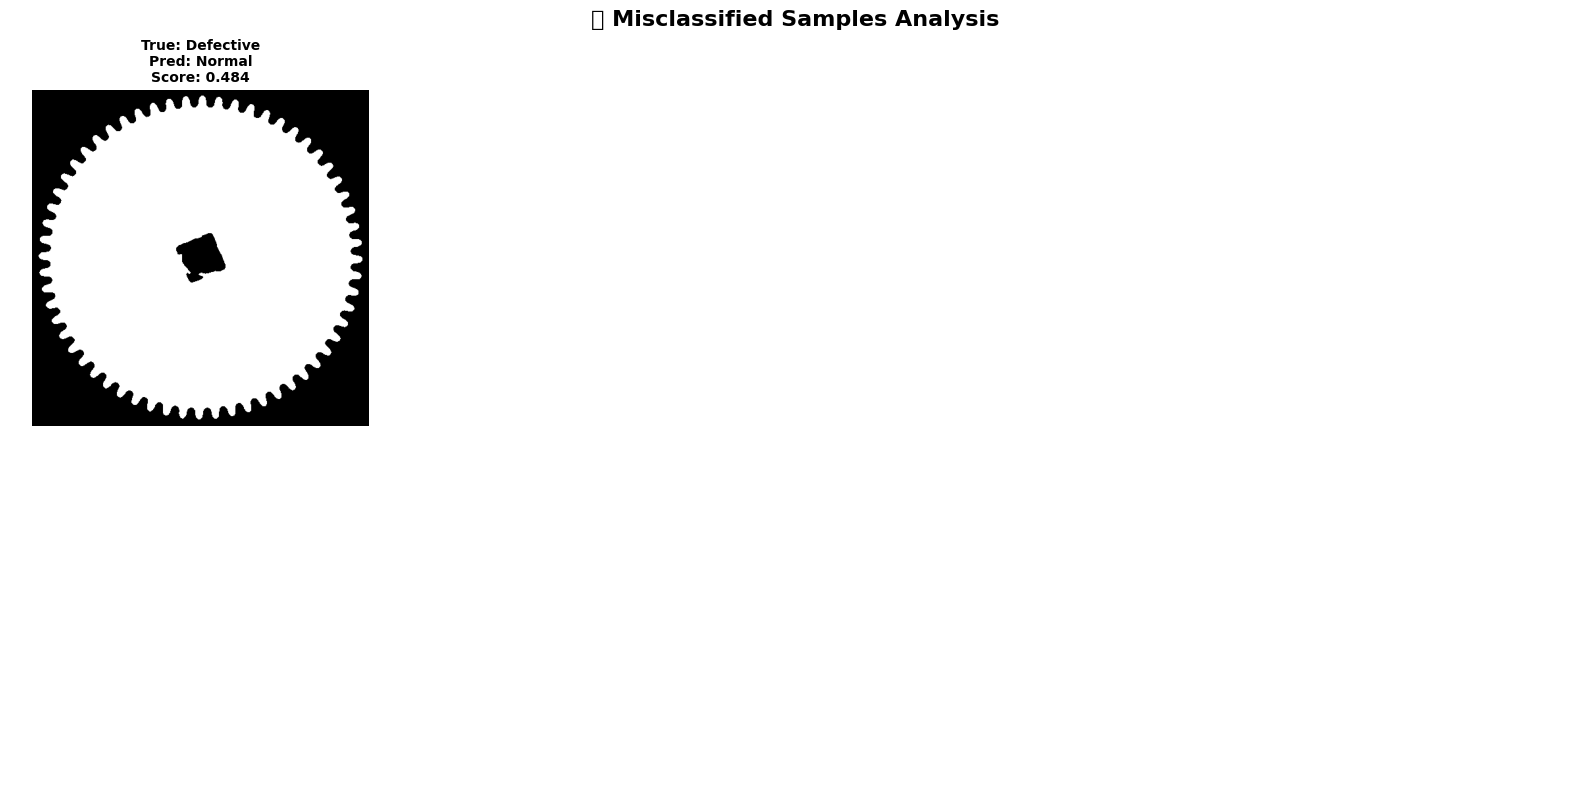


🔍 Error Analysis:
   False Positives: 0
   False Negatives: 1


In [14]:
inspect_misclassified_samples(model, test_dataset, episodes)

📈 ROC/PR VALIDATION: Checking AUC vs Accuracy consistency


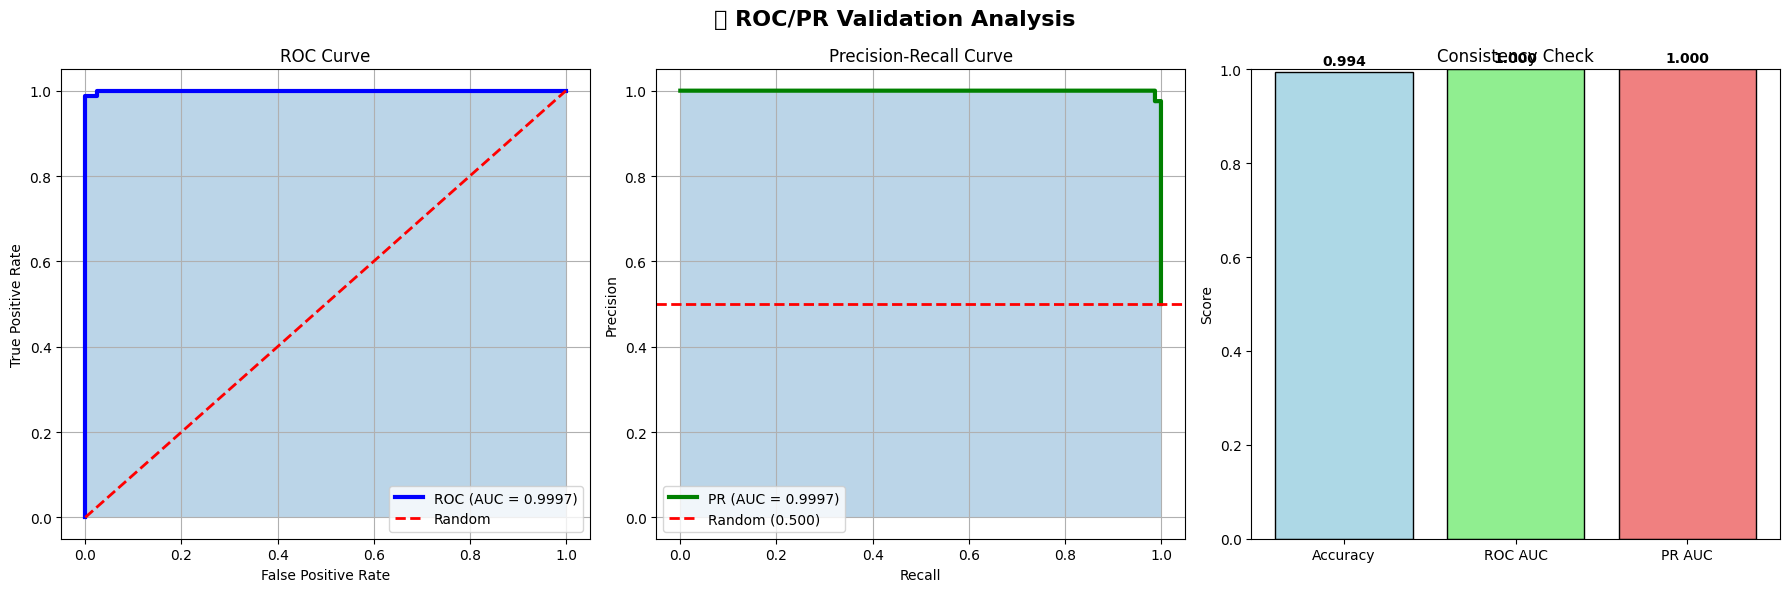


📊 Consistency Analysis:
   Accuracy:  0.9938
   ROC AUC:   0.9997
   PR AUC:    0.9997
   Difference (ROC-Acc): 0.0059
   ✅ CONSISTENT: ROC AUC matches accuracy


In [15]:
validate_roc_pr_curves(model, test_dataset, episodes)

🧠 FEATURE ANALYSIS: Checking if model learns meaningful patterns
   Computing t-SNE...


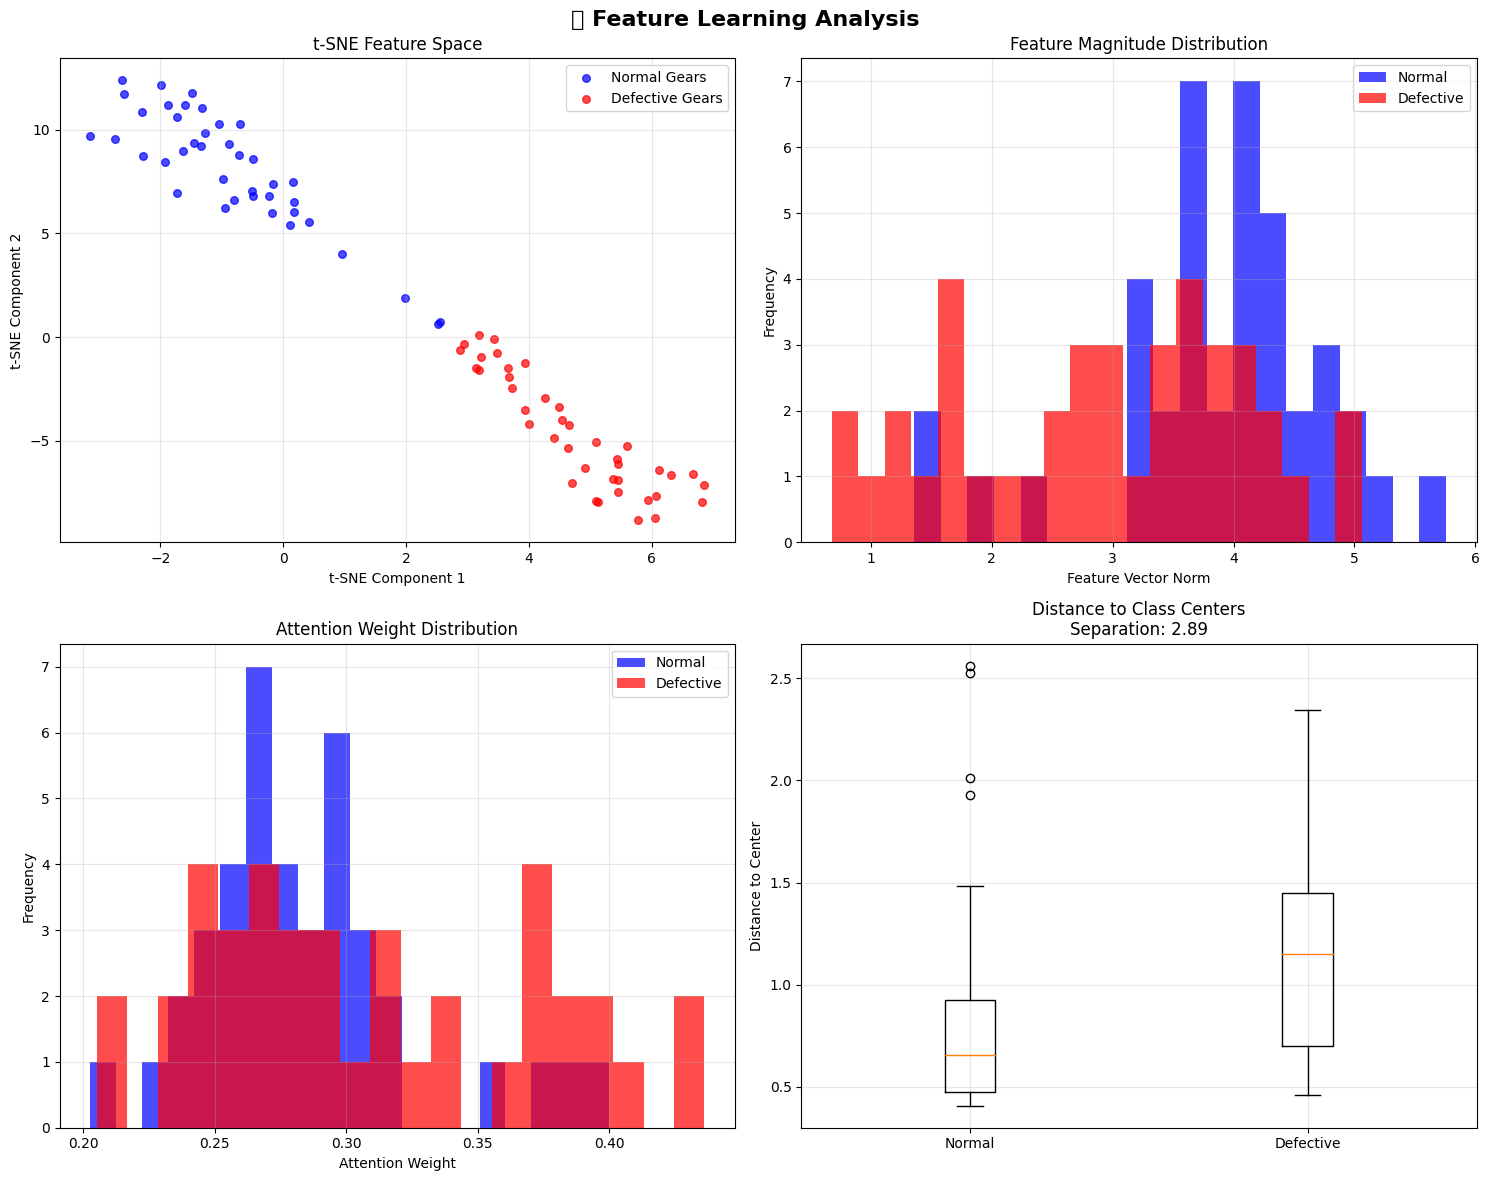


🧠 Feature Analysis Results:
   Class separation distance: 2.892
   Avg attention (normal):    0.284
   Avg attention (defective): 0.309
   ✅ EXCELLENT: Clear feature separation between classes


In [16]:
analyze_learned_features(model, test_dataset, episodes)